In [1]:
import pandas as pd
import numpy as np
import torchviz
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from torch.utils.tensorboard import SummaryWriter
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import joblib
from sklearn.preprocessing import MinMaxScaler
import time
import warnings
warnings.simplefilter('ignore')
def get_col(df,name):
    return df.columns[df.columns.str.contains(name)].tolist()

# load data

In [2]:
tag = pd.read_csv('../data/tag_cleaned.csv',index_col=0)
tag_map = dict(zip(tag.TAG,tag.chinese))

In [3]:
df = pd.read_csv('../data/train_cleaned.csv',index_col=0,parse_dates=True)
print(df.shape)
df.sample(5)

(193824, 95)


,MLPAP_TJ-0706B02,MLPAP_TJ-0706B03,MLPAP_TJ-0706B04,MLPAP_TJ-0706B05,MLPAP_TJ-0706B06,MLPAP_TJ-0706B07,MLPAP_TJ-0706B08,MLPAP_TJ-0706B09,MLPAP_TJ-0706B10,MLPAP_TJ-0706B11,...,MLPAP_FR-0755PV(轉換後),MLPAP_FR-0791.PV,MLPAP_FI-V211.PV(轉換後),MLPAP_PI-0658.PV,MLPAP_TJC-0757.PV,MLPAP_V225-PHD,MLPAP_PI-0771.PV,MLPAP_TRC-0747.PV,Unnamed: 96,MLPAP_TRC-0497.PV
2017-11-13 16:00:00,380.424866,399.251648,404.996704,410.999954,405.985001,405.949966,403.323456,405.225098,404.789886,400.000000,...,19.392302,29.377710,NaN,469.173676,-0.174338,0.022,144.510056,172.002563,NaN,7475.500000
2017-06-18 06:50:00,375.000000,392.003876,397.004456,403.000000,398.534378,399.000000,398.275696,402.429535,402.015900,396.681946,...,14.813566,32.564932,NaN,485.019409,1.963267,0.027,127.281876,173.550034,NaN,7670.765869
2016-05-09 18:40:00,404.000000,406.000000,405.000000,406.849854,406.000000,405.000000,404.446091,407.000000,406.000000,405.000000,...,4.157625,NaN,NaN,NaN,1.129989,0.009,NaN,144.908150,NaN,8237.234375
2018-01-24 23:50:00,380.000000,398.514572,404.054382,410.079117,405.412781,405.749939,403.000000,405.000000,403.900009,399.637726,...,16.743345,30.904644,NaN,478.626175,0.003379,0.021,161.414307,172.299995,NaN,8618.322754
2019-06-15 22:40:00,382.000000,395.772507,397.844543,402.000000,399.000000,399.171722,399.000000,397.000000,396.372131,393.000000,...,9.739496,30.140593,6717.63916,NaN,-0.307390,0.021,131.323509,168.300003,NaN,8388.000000


# add total_stream

In [4]:
stream_cols = tag[tag.chinese.str.contains('蒸氣')== True].TAG.tolist()
print(stream_cols)
df['stream'] = df[stream_cols[0]]*1000 + df[stream_cols[1]]*1000
df['stream'].describe()

['MLPAP_FR-0755PV(轉換後)', 'MLPAP_FR-0791.PV', 'MLPAP_FI-V211.PV(轉換後)']


count    141898.000000
mean      44142.045012
std        5465.257311
min       12644.887447
25%       41171.700358
50%       45572.840691
75%       48089.788318
max       49645.133972
Name: stream, dtype: float64

# define columns

In [5]:
action = tag[tag['category']=='可控制因子']['TAG'].values.tolist()
action.remove('MLPAP_FQ-0619.PV')
action.remove('MLPAP_TJC-0757.PV')
action.remove('MLPAP_PIC-0741.PV')
action.insert(0,'MLPAP_FQ-0619.PV')

output = get_col(df,'0997')

stream = ['stream']

state = get_col(df,'DATA OF USE')

print('action:',action)
print()

print('output:',output)
print()

print('stream:',stream)
print()

print('state:',state)

action: ['MLPAP_FQ-0619.PV', 'MLPAP_TJC-0627.PV', 'MLPAP_TRC-0610.PV', 'MLPAP_FR-0632.PV', 'MLPAP_TJC-0757A.PV', 'MLPAP_LIC-0738.PV', 'MLPAP_PIC-0761.PV', 'MLPAP_TRC-0762.PV', 'MLPAP_LRC-0729.PV', 'MLPAP_TJC-1721.PV', 'MLPAP_TRC-1734.PV', 'MLPAP_TRC-0747.PV', 'MLPAP_TJ-0757B.PV']

output: ['MLPAP_FQI-0997.PV']

stream: ['stream']

state: ['DATA OF USE']


# select columns

In [6]:
df = df[state + action + output + stream]

# look miss value

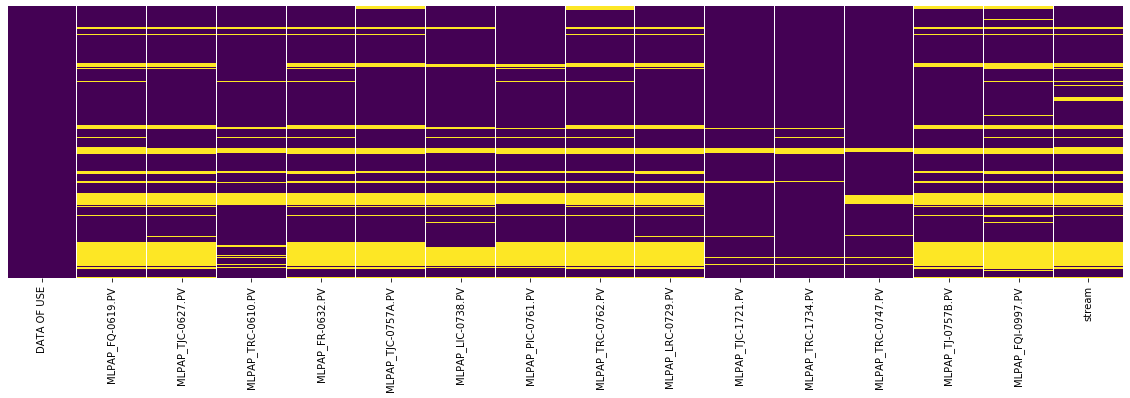

In [7]:
fig = plt.figure(figsize=(20,5))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

# scale data

In [8]:
mm_state = MinMaxScaler()
mm_action = MinMaxScaler()
mm_output = MinMaxScaler()
mm_stream = MinMaxScaler()

df[state] = mm_state.fit_transform(df[state])
df[action] = mm_action.fit_transform(df[action])
df[output] = mm_output.fit_transform(df[output])
df[stream] = mm_stream.fit_transform(df[stream])

df.sample(5)

,DATA OF USE,MLPAP_FQ-0619.PV,MLPAP_TJC-0627.PV,MLPAP_TRC-0610.PV,MLPAP_FR-0632.PV,MLPAP_TJC-0757A.PV,MLPAP_LIC-0738.PV,MLPAP_PIC-0761.PV,MLPAP_TRC-0762.PV,MLPAP_LRC-0729.PV,MLPAP_TJC-1721.PV,MLPAP_TRC-1734.PV,MLPAP_TRC-0747.PV,MLPAP_TJ-0757B.PV,MLPAP_FQI-0997.PV,stream
2018-06-05 15:50:00,0.562889,0.977509,0.620553,0.610692,0.992515,0.259675,0.370490,0.945792,0.583743,0.393437,0.416925,0.551488,0.839319,0.267471,0.775921,0.973420
2019-03-18 20:40:00,0.775527,0.312627,0.714117,0.614348,0.621226,0.247081,0.825335,0.927718,0.405191,0.637208,0.421005,0.497535,0.861568,0.280251,NaN,0.258440
2018-06-21 13:10:00,0.574694,0.990789,0.621499,0.599444,0.993136,0.270287,0.548287,0.946175,0.582166,0.536384,0.423092,0.547405,0.835923,0.283696,0.776941,0.985130
2017-09-01 19:00:00,0.357186,0.965589,0.338685,0.666449,0.941816,0.088908,0.622794,0.925628,0.419679,0.411599,0.414227,0.437014,0.843406,0.122656,0.737745,0.969679
2019-11-09 21:00:00,0.950877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.457616,0.632424,0.384634,NaN,NaN,NaN


# build dataset for modeling

In [9]:
def build_dataset(df,n):
    data = {'state':[],'action':[],'output':[],'stream':[],'idx':[]}
    for i in tqdm(range(0,len(df)-n)):
        curr = df.iloc[i:i+n] #一小段資料
        if np.isnan(curr.values).sum() == 0: #確保這段資料無缺失值
            
            data['state'].append(curr[state].values.mean())#這段時間的觸媒使用時間 均值
            data['action'].append(curr[action].values)# 這段時間 "所有" 操作
            data['output'].append(curr[output].values[-1])#這段時間 最後一個時間點 的出料
            data['stream'].append(curr[stream].median())#這段時間蒸氣的 中位數
            data['idx'].append(curr.index[-1]) #這段時間最後 出料對應的時間點
    
    # reshape
    data['state'] = np.array(data['state']).reshape(-1,1)
    data['action'] = np.array(data['action'])
    data['output'] = np.array(data['output']).reshape(-1,1)
    data['stream'] = np.array(data['stream']).reshape(-1,1)
    
    # store scaler
    data['mm_state'] = mm_state
    data['mm_action'] = mm_action
    data['mm_output'] = mm_output
    data['mm_stream'] = mm_stream
    
    # store col_name
    data['state_col'] = state
    data['action_col'] = action
    data['output_col'] = output
    data['stream_col'] = stream
    
    return data

In [10]:
data = build_dataset(df,36)

In [11]:
print(len(data['idx']))

130151


# save

In [12]:
joblib.dump(data,'../data/dataset.pkl')

['../data/dataset.pkl']